In [1]:
# Loading needed libraries
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim

## Analysis of Total Reviews

In [2]:
# load reviews data
reviews = pd.read_csv("reviews_T.csv")

In [3]:
# create one object chain of all reviews
for col in reviews:
    if col == '133189':
        raw_reviews = reviews['133189'].dropna()
    else:
        raw_reviews = raw_reviews.append(reviews[col].dropna(), ignore_index = True)

In [4]:
raw_reviews

0      2nd kayak purchase from REI. Upgraded a Lifeti...
1      I’m new to kayaking and wanted to get a boat m...
2      I loved this kayak for the price and I got it ...
3      I now live right on the banks of the Sassafras...
4      I like this boat for the price. It is easy to ...
                             ...                        
331    I purchased the Eddyline Whisper tandem used a...
332    We bought our Whisper from REI two years ago a...
333    This is some piece of work. Great style, elega...
334    Owned for a year now and I love it. Tracks gre...
335                                           No reviews
Length: 336, dtype: object

In [5]:
# Process raw reviews to get rid of punctuation, stop words, short words, and make all words lower case.

proc_reviews = raw_reviews.str.replace("[^a-zA-Z#]", " ")

stop_words = stopwords.words('english')
stop_words = stop_words + ['get', 'also', 'one', 'two', 'would', 'the', 'reviews']

def remove_stopwords(review):
    review_new = " ".join([i for i in review if i not in stop_words])
    return review_new

proc_reviews = proc_reviews.apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))
proc_reviews = [review.lower() for review in proc_reviews]
proc_reviews = [remove_stopwords(review.split()) for review in proc_reviews]


In [6]:
# split reviews and add to a single list for frequency distribution and word cloud.
reviews_list = []
for review in proc_reviews:
    reviews_list.extend(review.split())

In [7]:
# Create a frequency distribution
def freq_words(x, terms = 30):

  fdist = FreqDist(x)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", palette='ocean')
  ax.set(ylabel = 'Count')
  plt.show()

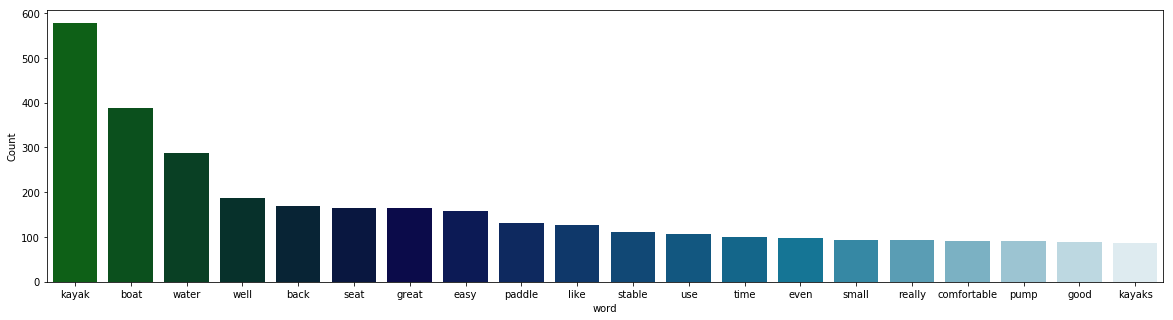

In [8]:
freq_words(reviews_list, terms = 20)

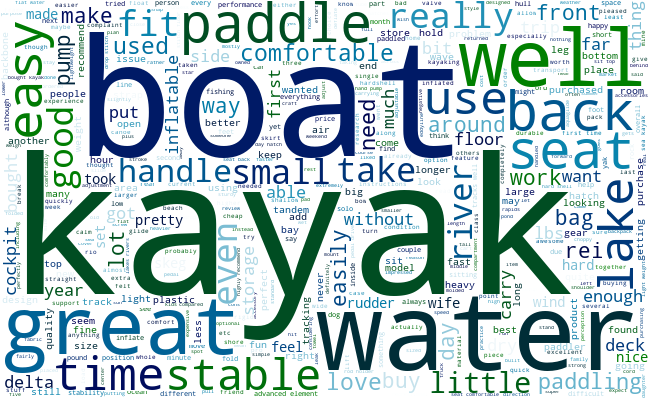

In [9]:
# Create a word cloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='black', colormap='ocean_r', width=650, height=400)
wordcloud.generate(','.join(reviews_list))
wordcloud.to_image()

In [10]:
# Tokenize reviews for LDA.
tokenized_reviews = pd.Series(proc_reviews).apply(lambda x: x.split())

In [11]:
# Fitting the LDA model

dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(review) for review in tokenized_reviews]
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50)

In [12]:
lda_model.print_topics()

[(0,
  '0.028*"kayak" + 0.012*"water" + 0.010*"boat" + 0.008*"great" + 0.008*"seat" + 0.007*"well" + 0.007*"back" + 0.006*"easy" + 0.005*"comfortable" + 0.005*"paddle"'),
 (1,
  '0.023*"kayak" + 0.008*"water" + 0.008*"back" + 0.008*"boat" + 0.006*"paddle" + 0.006*"lake" + 0.006*"seat" + 0.006*"pump" + 0.005*"time" + 0.005*"use"'),
 (2,
  '0.011*"kayak" + 0.006*"service" + 0.005*"oru" + 0.005*"rei" + 0.004*"customer" + 0.004*"replacement" + 0.004*"time" + 0.003*"first" + 0.003*"seat" + 0.003*"much"'),
 (3,
  '0.017*"boat" + 0.008*"water" + 0.007*"floor" + 0.005*"kayak" + 0.005*"like" + 0.004*"lbs" + 0.004*"back" + 0.004*"paddle" + 0.004*"small" + 0.004*"great"'),
 (4,
  '0.029*"boat" + 0.014*"kayak" + 0.012*"water" + 0.011*"well" + 0.009*"easy" + 0.006*"great" + 0.005*"bag" + 0.005*"pump" + 0.005*"stable" + 0.005*"like"')]

In [13]:
# Visualizing using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.062526 -0.004777       1        1  43.648849
1     -0.024720 -0.057822       2        1  20.736593
4     -0.048102 -0.015151       3        1  19.668341
3     -0.002680  0.093730       4        1  11.609679
2      0.138028 -0.015980       5        1   4.336540, topic_info=     Category        Freq     Term       Total  loglift  logprob
3     Default  332.000000     boat  332.000000  30.0000  30.0000
20    Default  508.000000    kayak  508.000000  29.0000  29.0000
476   Default   53.000000    floor   53.000000  28.0000  28.0000
3015  Default   24.000000      oru   24.000000  27.0000  27.0000
39    Default   59.000000      rei   59.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
324    Topic5    2.442626  quality   30.999321   0.5972  -6.0600
56     Topic5    2.514909     able   47.501877   0.1996  -6.0308
242    Topic5    2.544900     used   69.056374  -0.1627  -6.0190
3      Topic5    2.933251     boat  332.371063  -1.5920  -5.8770
55     Topic5    2.458174     well  164.411392  -1.0649  -6.0537

[431 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
56        1  0.399984  able
56        2  0.189466  able
56        3  0.273673  able
56        4  0.063155  able
56        5  0.063155  able
...     ...       ...   ...
165       2  0.420765  year
165       3  0.114754  year
165       4  0.038251  year
165       5  0.076503  year
2874      5  0.520425  yoga

[814 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 3])

## Analysis of Recreational Reviews only

In [14]:
# load products data and transformed reviews data
products = pd.read_csv('products_proc.csv')
reviews_T = pd.read_csv("reviews_T.csv")

In [15]:
# add reviews and products data together. Each column is a product.
reviews_T.columns = range(0,66)
products_T = products.T
products_T = products_T.drop(products_T.index[1:20], axis = 0)
products_T = products_T.drop('price_category', axis = 0)
reviews_type = pd.concat([products_T.loc[['type']], reviews_T],axis=0)

In [16]:
#Filter for only recreational kayaks
flatwater_reviews = reviews_type.T[reviews_type.T['type']=='Flatwater']

In [17]:
# Transform back to each column is a product and drop the 'type' row, as it is no longer needed.
flatwater_reviews = flatwater_reviews.T
flatwater_reviews = flatwater_reviews.drop('type', axis = 0)

In [18]:
# create one object chain of all reviews
for col in flatwater_reviews:
    if col == 0:
        raw_reviews = flatwater_reviews[0].dropna()
    else:
        raw_reviews = raw_reviews.append(flatwater_reviews[col].dropna(), ignore_index = True)

In [19]:
# Process raw reviews to get rid of punctuation, stop words, short words, and make all words lower case.

proc_reviews = raw_reviews.str.replace("[^a-zA-Z#]", " ")

stop_words = stopwords.words('english')
stop_words = stop_words + ['get', 'also', 'one', 'two', 'would', 'the', 'reviews']

def remove_stopwords(review):
    rev_new = " ".join([i for i in review if i not in stop_words])
    return rev_new

proc_reviews = proc_reviews.apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))
proc_reviews = [review.lower() for review in proc_reviews]
proc_reviews = [remove_stopwords(review.split()) for review in proc_reviews]

In [20]:
# split reviews and add to one list for frequency distribution and word cloud.
reviews_list = []
for review in proc_reviews:
    reviews_list.extend(review.split())

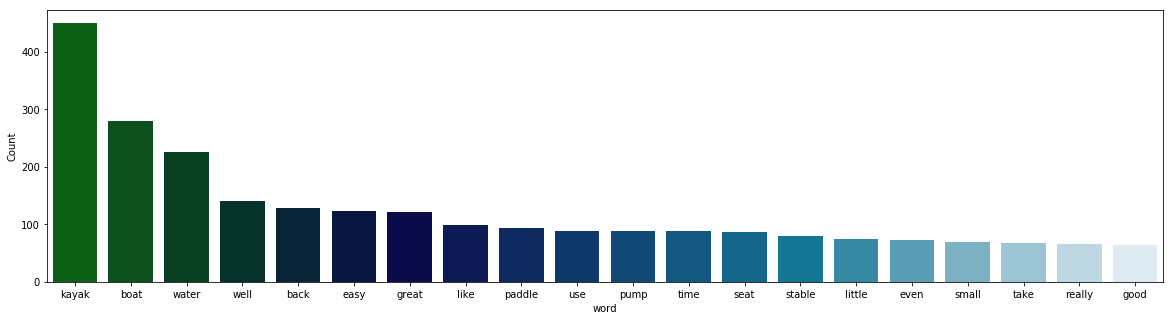

In [21]:
# Create a frequency distribution

def freq_words(x, terms = 30):

  fdist = FreqDist(x)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top N most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", palette='ocean')
  ax.set(ylabel = 'Count')
  plt.show()
freq_words(reviews_list, terms = 20)

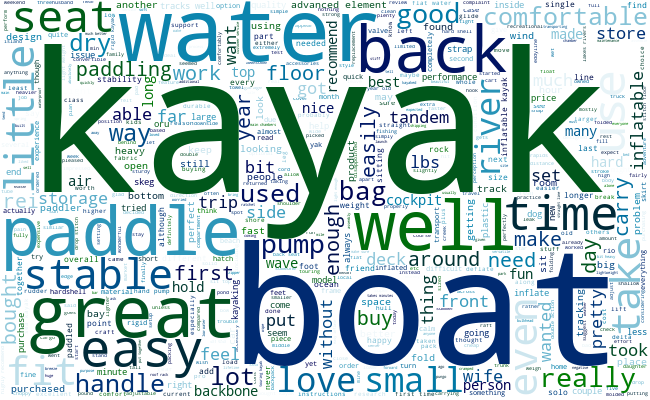

In [22]:
# Create a word cloud

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='black', colormap='ocean_r', width=650, height=400)
wordcloud.generate(','.join(reviews_list))
wordcloud.to_image()

In [23]:
# Tokenize reviews for LDA.

tokenized_reviews = pd.Series(proc_reviews).apply(lambda x: x.split())
tokenized_reviews

0      [kayak, purchase, rei, upgraded, lifetime, lot...
1      [new, kayaking, wanted, boat, daughter, age, f...
2      [loved, kayak, price, got, additional, looking...
3      [live, right, banks, sassafras, river, upper, ...
4      [like, boat, price, easy, paddle, light, enoug...
                             ...                        
246    [purchased, model, years, ago, continue, use, ...
247    [purchased, eddyline, whisper, tandem, used, w...
248    [bought, whisper, rei, years, ago, since, padd...
249    [piece, work, great, style, elegant, super, gl...
250                                                   []
Length: 251, dtype: object

In [24]:
# Fitting the LDA model

dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(review) for review in tokenized_reviews]
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50)

In [25]:
lda_model.print_topics()

[(0,
  '0.023*"kayak" + 0.014*"boat" + 0.009*"water" + 0.007*"easy" + 0.006*"floor" + 0.005*"paddle" + 0.005*"back" + 0.005*"stable" + 0.005*"like" + 0.005*"well"'),
 (1,
  '0.019*"kayak" + 0.009*"use" + 0.009*"pump" + 0.008*"boat" + 0.007*"easy" + 0.007*"water" + 0.006*"back" + 0.006*"great" + 0.005*"dry" + 0.005*"bag"'),
 (2,
  '0.021*"kayak" + 0.014*"water" + 0.009*"seat" + 0.007*"back" + 0.007*"like" + 0.007*"love" + 0.006*"little" + 0.005*"boat" + 0.004*"well" + 0.004*"storage"'),
 (3,
  '0.019*"kayak" + 0.016*"boat" + 0.012*"water" + 0.007*"pump" + 0.006*"back" + 0.006*"like" + 0.006*"well" + 0.005*"really" + 0.005*"time" + 0.005*"small"'),
 (4,
  '0.021*"kayak" + 0.015*"boat" + 0.012*"well" + 0.011*"water" + 0.011*"great" + 0.009*"paddle" + 0.006*"seat" + 0.006*"kayaks" + 0.006*"comfortable" + 0.006*"back"')]

In [28]:
# Visualizing using pyLDAvis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.031916  0.092648       1        1  26.068628
4     -0.042913 -0.027469       2        1  23.701624
0      0.031178 -0.020125       3        1  23.596062
1      0.066509 -0.048395       4        1  15.794772
2     -0.086690  0.003340       5        1  10.838910, topic_info=    Category        Freq    Term       Total  loglift  logprob
554  Default   75.000000    pump   75.000000  30.0000  30.0000
43   Default   71.000000    seat   71.000000  29.0000  29.0000
290  Default   49.000000    love   49.000000  28.0000  28.0000
20   Default  375.000000   kayak  375.000000  27.0000  27.0000
53   Default  188.000000   water  188.000000  26.0000  26.0000
..       ...         ...     ...         ...      ...      ...
127   Topic5    5.514898    much   47.655682   0.0655  -5.8718
397   Topic5    4.383288    skeg   19.873371   0.7104  -6.1015
21    Topic5    5.203986    lake   51.230053  -0.0649  -5.9298
17    Topic5    5.818871   great  102.281525  -0.6446  -5.8182
31    Topic5    5.288952  paddle   78.957489  -0.4813  -5.9136

[406 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3318      5  0.873472    abrasion
1037      1  0.878757   according
1757      4  0.825425        adds
2008      3  0.791519         adn
716       3  0.679537  adventures
...     ...       ...         ...
850       2  0.204794       worry
850       4  0.614383       worry
914       1  0.783181   yesterday
914       4  0.195795   yesterday
1825      3  0.887612        zero

[785 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 3])